In [1]:
# this is MuZero!
# https://arxiv.org/abs/1911.08265
# It works, but only for CartPole
# Would be happy if it worked for Follower, LunarLander, or Acrobot
# Also, while it's written, it's not using mcts.
# Replace naive_search(which tries n**K) with mcts_search to use

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import tensorflow as tf
import numpy as np
import gym
from tqdm import tqdm, trange
import os,sys
sys.path.append(os.getcwd())

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print(tf.config.list_physical_devices())
with tf.device('/GPU'):
  a = tf.random.normal(shape=(2,), dtype=tf.float32)
  b = tf.nn.relu(a)

print(a)
print(b)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
tf.Tensor([-1.1339291   0.09491836], shape=(2,), dtype=float32)
tf.Tensor([0.         0.09491836], shape=(2,), dtype=float32)


In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3110921097457617439
 xla_global_id: -1]

In [5]:
# Make Follower work! Will give interview to anyone who does.
from muzero.follower import Follower
#env = Follower()
env = gym.make("CartPole-v0")
#env = gym.make("MountainCar-v0")
#env = gym.make("LunarLander-v2")
#env = gym.make("Acrobot-v1")

from muzero.model import MuModel
m = MuModel(env.observation_space.shape, env.action_space.n, s_dim=128, K=3, lr=0.001)
print(env.observation_space.shape, env.action_space.n)

from muzero.game import Game, ReplayBuffer
from muzero.mcts import naive_search, mcts_search
replay_buffer = ReplayBuffer(50, 128, m.K)
rews = []

(4,) 2


In [6]:
def play_game(env, m):
  import random
  game = Game(env, discount=0.997)
  while not game.terminal():
    game.env.render()
    cc = random.random()
    if cc < 0.05:
      policy = [1/m.a_dim]*m.a_dim
    else:
      policy = naive_search(m, game.observation, T=1)
    game.act_with_policy(policy)
  return game

In [7]:
from muzero.model import reformat_batch
import collections

for j in range(30):
  game = play_game(env, m)
  replay_buffer.save_game(game)
  for i in range(20):
    m.train_on_batch(replay_buffer.sample_batch())
  rew = sum(game.rewards)
  rews.append(rew)
  print(len(game.history), rew, collections.Counter(game.history), m.losses[-1][0])

2022-05-15 22:08:16.450083: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


22 22.0 Counter({0: 16, 1: 6}) 55.75950241088867
12 12.0 Counter({1: 8, 0: 4}) 121.04840087890625
17 17.0 Counter({1: 11, 0: 6}) 108.85542297363281
10 10.0 Counter({1: 8, 0: 2}) 48.28778839111328
11 11.0 Counter({1: 9, 0: 2}) 33.96978759765625
48 48.0 Counter({0: 28, 1: 20}) 297.8573913574219
190 190.0 Counter({1: 102, 0: 88}) 2397.211181640625
24 24.0 Counter({0: 14, 1: 10}) 1678.2955322265625
18 18.0 Counter({0: 9, 1: 9}) 3064.04345703125
10 10.0 Counter({1: 8, 0: 2}) 1955.015869140625
10 10.0 Counter({1: 9, 0: 1}) 1355.574951171875
24 24.0 Counter({1: 16, 0: 8}) 1294.2293701171875
13 13.0 Counter({0: 9, 1: 4}) 855.23486328125
14 14.0 Counter({0: 7, 1: 7}) 225.72723388671875
23 23.0 Counter({1: 16, 0: 7}) 1322.025390625
63 63.0 Counter({0: 35, 1: 28}) 836.2350463867188
200 200.0 Counter({1: 102, 0: 98}) 1250.576416015625
200 200.0 Counter({1: 104, 0: 96}) 3180.537109375
177 177.0 Counter({1: 93, 0: 84}) 4732.6689453125
15 15.0 Counter({1: 9, 0: 6}) 3160.9169921875
11 11.0 Counter({1:

NameError: name 'figure' is not defined

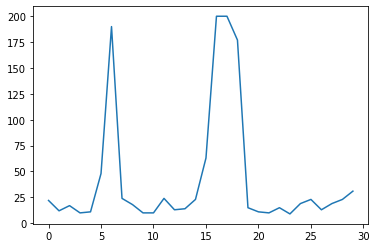

In [10]:
import matplotlib.pyplot as plt
plt.plot(rews)
figure()
plt.yscale('log')
plt.plot([x[0] for x in m.losses])
plt.plot([x[1] for x in m.losses])
plt.plot([x[-3] for x in m.losses])

In [29]:
# can act?
state = env.reset()
for sn in range(2000):
  p_0 = naive_search(m, state, debug=False, T=0.1)
  #p_0, _ = mcts_search(m, state, 50)
  a_1 = np.random.choice(list(range(len(p_0))), p=p_0)
  _, v_0 = m.ft(m.ht(state))
  
  env.render()
  state,r,done,_ = env.step(a_1)
  print(a_1, v_0, r, p_0)
  if done:
    print("DONE", sn)
    break

2022-05-14 15:42:25.773891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-14 15:42:25.820710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1 -0.008646967 1.0 [7.47420596e-08 9.99999925e-01]
1 0.12866507 1.0 [4.51027857e-08 9.99999955e-01]
1 0.24153459 1.0 [4.47458038e-08 9.99999955e-01]
1 0.33642784 1.0 [5.98364497e-08 9.99999940e-01]
1 0.4178146 1.0 [8.64166554e-08 9.99999914e-01]
1 0.48881316 1.0 [1.24498941e-07 9.99999876e-01]
1 0.5516392 1.0 [1.83802153e-07 9.99999816e-01]
1 0.6078521 1.0 [2.68841717e-07 9.99999731e-01]
1 0.6585767 1.0 [3.78021156e-07 9.99999622e-01]
DONE 8
